# Implémentation d'un algorithme de Deep Q-Learning autour du problème de gestion de la circulation sur un carrefour automobile

Prérequis : Connaissance en Q-Learning (sous-domaine du Reinforcement Learning/Apprentissage par renforcement), Deep Learning avec réseaux de neurones profonds, Package [Cityflow](https://github.com/cityflow-project/CityFlow) installé dans un environnement Anaconda dédié dans un os Linux 

In [1]:
import cityflow 
import os 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm

### Initialisation de l'environnement 

In [2]:
path = os.getcwd()
path

'/home/vintel38/MyCityFlow'

In [3]:
# config_path=os.path.join(path,"test1","config.json")
# eng = cityflow.Engine(config_path, thread_num=1)

### Initialisation du buffer et de ses opérations possibles

In [4]:
from collections import deque 

def sample_buffer(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, next_states, rewards = [np.array([experience[field_index] for experience in batch]) 
                                             for field_index in range(4)]
    return states, actions, next_states, rewards

def fill_buffer(experiences):
    replay_buffer.append(experiences)
    
## random shuffling of numpy.random.shuffle of replay_buffer

### Initialisation de l'agent et de ses opérations possibles

In [5]:
def create_DNN(n_inputs, n_outputs):
    model = tf.keras.models.Sequential([
        keras.layers.Dense(64, activation="elu", input_shape=n_inputs),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Dense(n_outputs)
    ])
    return model

def epsilon_policy(state, epsilon, n_outputs):
    if epsilon > np.random.rand():
        return np.random.randint(n_outputs)
    else:
        Q_values = modelTrain.predict(state[np.newaxis])
        return np.argmax(Q_values[0])
    
def play_step(eng, state, epsilon, n_outputs):
    action = epsilon_policy(state, epsilon, n_outputs)
    prereward=sum(np.array(list(eng.get_lane_waiting_vehicle_count().values())))
    eng.set_tl_phase("intersection_1_1", action)
    eng.next_step()
    next_state=np.array(list(eng.get_lane_waiting_vehicle_count().values()))
    reward=prereward-sum(next_state)
    fill_buffer((state, action, next_state, reward))
    return state, action, next_state, reward



### Procédure d'entraînement 

Avant de commencer à entraîner le réseau de neurones à gérer la signalisation du carrefour, il est nécessaire de bien initialiser les parties prenantes de l'architecture et leurs interactions.

L'état (state) est représenté par un vecteur colonne où chaque valeur correspond aux nombres de voitures à l'arrêt sur chaque ligne qui peut être représenté par la sortie de `eng.get_lane_waiting_vehicle_count()`. Ce vecteur a donc une taille de 1 x 12 dans notre cas d'intersection simplifiée. La récompense est définie comme le nombre de voiture mises en mouvement par intervalle de temps. Cette modélisation est simplifiée mais on peut vérifier si elle fonctionne. 

In [6]:
batch_size=32
gamma=0.95 # discount factor
optimizer=keras.optimizers.Adam(lr=1e-3)
loss_fn=keras.losses.mean_squared_error

def training_step(batch_size):
    states, actions, next_states, rewards = sample_buffer(batch_size)
    
    # calcul de la Qvalues target
    Qval_futur = modelTarget.predict(next_states)
    max_Qval_futur = np.max(Qval_futur, axis=1)
    Qtarget = (rewards + gamma * max_Qval_futur)
    
    # calcul de la Qvalues training
    mask= tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        Qval_actual = modelTrain(states)
        Qtraining = tf.reduce_sum(Qval_actual*mask, axis=1, keepdims=True)
        
        # calcul de la loss
        loss = tf.reduce_mean(loss_fn(Qtarget, Qtraining))
        
    # calcul des gradients et 
    # application de la Gradient Descent procedure sur les poids du réseau de neurones
    grads = tape.gradient(loss, modelTrain.trainable_variables)
    optimizer.apply_gradients(zip(grads, modelTrain.trainable_variables))
    return loss

In [7]:
# Initialisation du buffer 
replay_buffer = deque(maxlen=2000)

# Initialisation de l'environnement 
path = os.getcwd()
config_path=os.path.join(path,"test1","config.json")
eng = cityflow.Engine(config_path, thread_num=1)

# Initialisation du Neural Network
n_inputs=24
n_outputs=9 # nombre de lightphases (combinaison de feux) possibles pour la seule intersection_1_1
# L'entrée du 2N consiste donc les 24 valeurs du décompte des voitures qui attendent sur chaque lane 
# lanes au nombre de 24 et la sortie est donc les 9 Qvalues associées aux lightphases possibles.

modelTrain = create_DNN([n_inputs],n_outputs)
modelTarget = create_DNN([n_inputs],n_outputs)
state = [0 for i in range(n_inputs)]
Rewards=[]

eng.reset(seed=False)
for episode in tqdm(range(500)):
    epsilon = max(1-episode/100, 0.01)
    state, action, next_state, reward = play_step(eng, state, epsilon, n_outputs)
    state=next_state
    
    Rewards.append(reward)
    
    if episode > 50:
        loss = training_step(batch_size)
        #Loss.append(loss)
        # ndlr hands on : loss is poor indicator of model performance
        
    if episode%5==0:
        modelTarget.set_weights(modelTrain.get_weights()) 
print('state {}'.format(state))

100%|██████████| 500/500 [01:01<00:00,  8.13it/s]

state [ 0 29  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0 25  0]


In [8]:
sum(state)

83

In [9]:
import matplotlib.pyplot as plt 

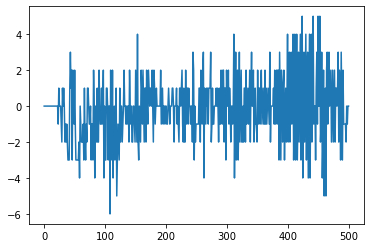

In [10]:
plt.plot(Rewards)